<a href="https://colab.research.google.com/github/sidchaini/GPTutorial/blob/main/Sessions/Session13/Day2/01-Introduction-to-GPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to Gaussian Processes

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4

## The Gaussian Distribution

In this notebook, we'll go over the very basics of Gaussian Processes (GPs) and how to construct and draw samples from them. But first, let's review some stuff about the Gausssian distribution $-$ the familiar bell curve $-$ itself.

We're probably all familiar with ``numpy``'s built-in ``np.random.randn()`` function, which draws a sample from the standard normal $ \mathcal{N}(0, 1) $, i.e., a Gaussian with zero mean and unit variance:

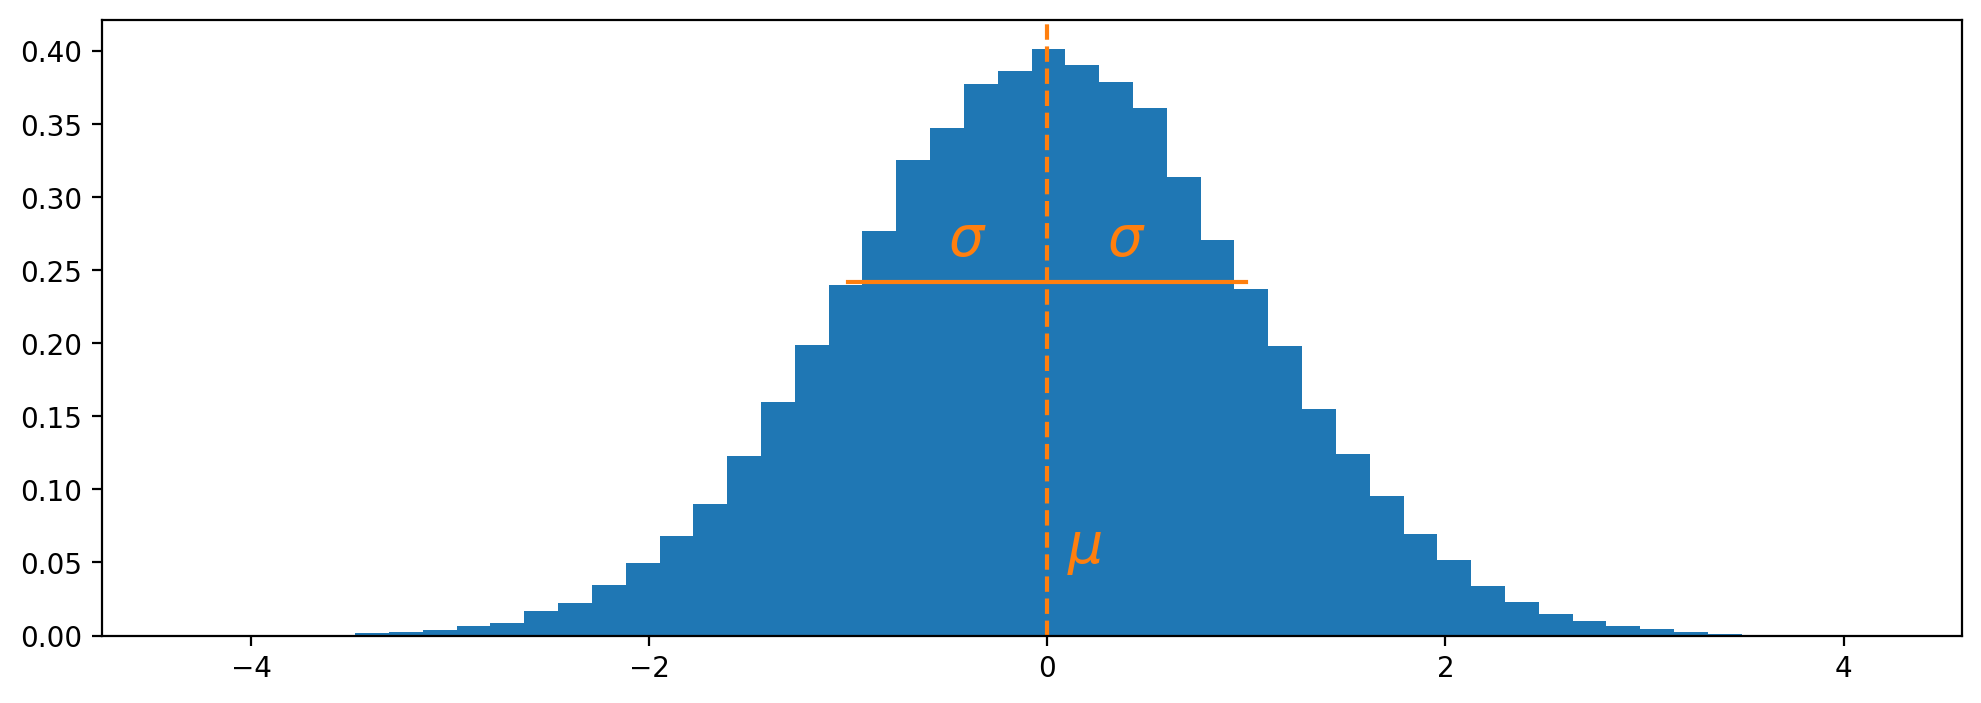

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
u = np.random.randn(100000)
plt.hist(u, bins=50, density=1);
plt.axvline(0, color="C1", ls="--")
y = np.exp(-0.5) / (np.sqrt(2 * np.pi))
plt.plot([-1, 1], [y, y], "C1-")
plt.text(0.1, 0.05, r"$\mu$", color="C1", fontsize=20);
plt.text(0.3, 0.26, r"$\sigma$", color="C1", fontsize=20);
plt.text(-0.5, 0.26, r"$\sigma$", color="C1", fontsize=20);

To draw from a Gaussian distribution with a different mean $\mu$, we simply *add* $\mu$ to $u$, and to draw from a distribution with different variance $\sigma^2$, we simply *multiply* $u$ by $\sigma$. We can therefore draw from a Gaussian with mean (say) $10.0$ and variance $5.0^2$ by running

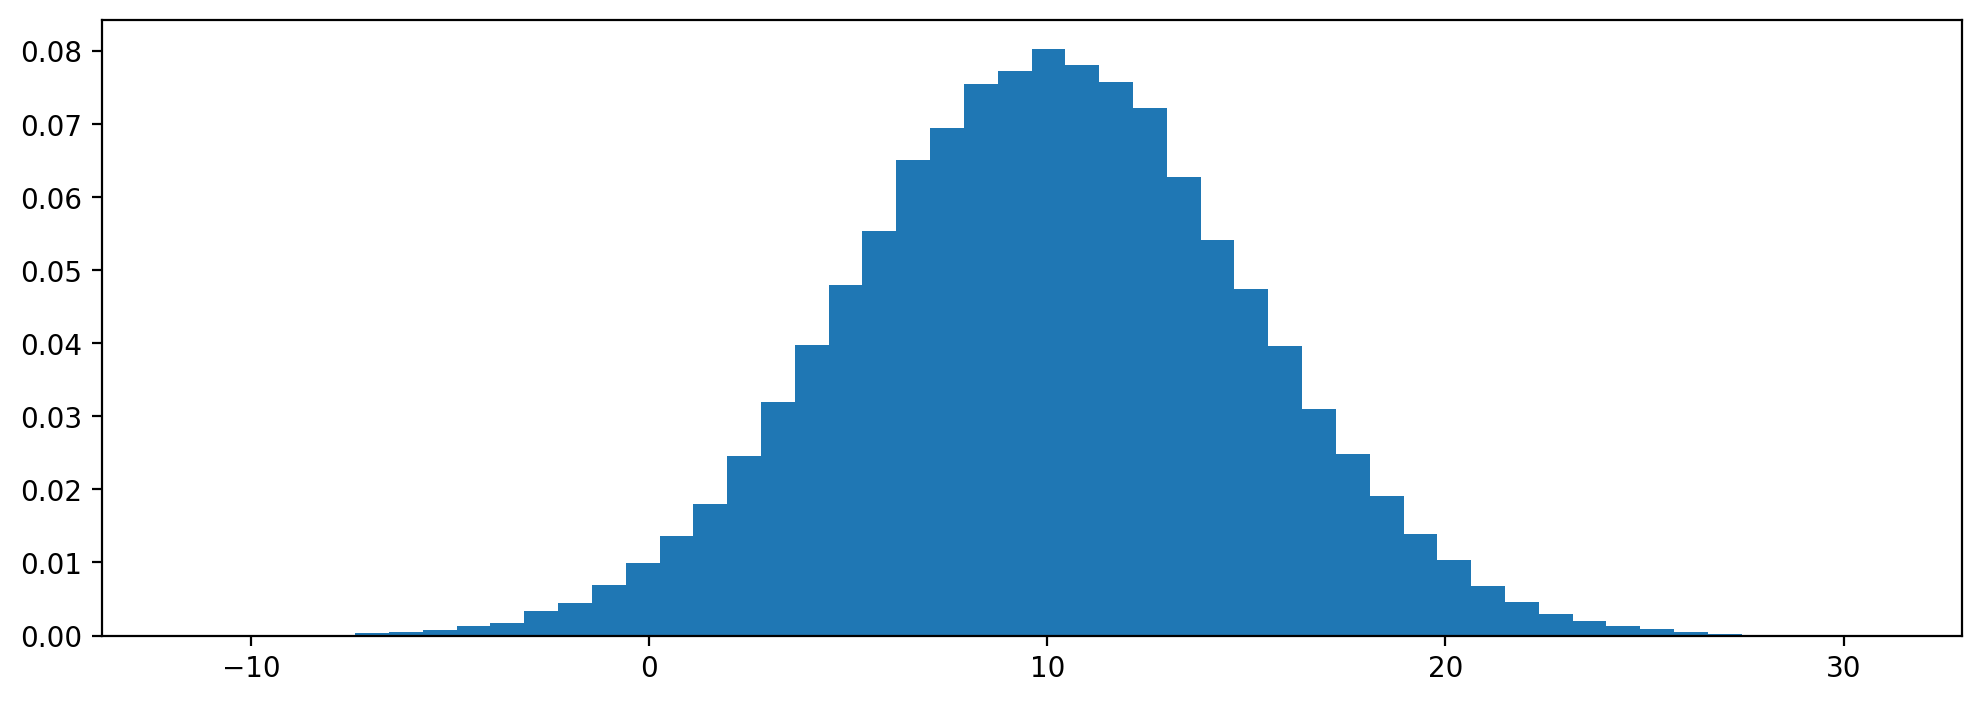

In [5]:
np.random.seed(1)
u = np.random.randn(100000)
plt.hist(10.0 + 5.0 * u, bins=50, density=1);

As I mentioned in my lecture, in a single dimension, the probability density function for a Gaussian with mean $\mu$ and variance $\sigma^2$ is

$$
p(y | \mu, \sigma^2) =
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left[
-\frac{1}{2}\left(\frac{y - \mu}{\sigma}\right)^2
\right]
$$

In Exercise 1 below, we'll derive the expression for a Gaussian in $N$ dimensions. We'll do it for the case where there isn't any covariance across the $N$ dimensions, in which case the probability density is obtained by multiplying the expression above $N$ times.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1</h1>
</div>

Show (numerically) that the probability function for an uncorrelated Gaussian in $N$ dimensions

$$
p(\mathbf{y} | \boldsymbol{\mu}, \mathbf{\Sigma}) =
\prod_{n=0}^{N-1}
\frac{1}{\sqrt{2\pi\sigma_n^2}}
\exp\left[
-\frac{1}{2}\left(\frac{y_n - \mu_n}{\sigma_n}\right)^2
\right]
$$

can be written in vector form as

$$
p(\mathbf{y} | \boldsymbol{\mu}, \mathbf{\Sigma}) =
\frac{1}{\sqrt{(2\pi)^N \mathrm{det}(\mathbf{\Sigma})}}
\exp\left[
-\frac{1}{2}
(\mathbf{y} - \boldsymbol{\mu})^\top
\mathbf{\Sigma}^{-1}
(\mathbf{y} - \boldsymbol{\mu})
\right]
$$

where

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 \sigma_0^2 & 0 & 0 \\
 0 & \sigma_1^2 & 0 \\
 0 & 0 & \ddots
\end{pmatrix}
$$

is a diagonal covariance matrix. You can use the following random inputs to test the equivalence of the two expressions:

In [ ]:
N = 5
y = np.array([1.0, 2.0, 0.5, 0.75, 1.1])
mu = np.array([0.7, 1.5, 0.8, 0.7, 1.3])
sigma = np.array([0.3, 0.5, 0.5, 0.4, 0.5])

Even though we derived the expression for the probability of a multidimensional Gaussian assuming no covariance between the different dimensions, the expression in Exercise 1 is general. In the most general case, the covariance matrix is allowed to have off-diagonal elements:

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 \mathrm{Var(x_0)} & \mathrm{Cov(x_0, x_1)} & \cdots & \mathrm{Cov(x_0, x_N)} \\ \\
 \mathrm{Cov(x_1, x_0)} & \mathrm{Var(x_1)} & \cdots & \mathrm{Cov(x_1, x_N)} \\ \\
 \vdots & \vdots & \ddots & \vdots \\ \\
 \mathrm{Cov(x_N, x_0)} & \mathrm{Cov(x_N, x_1)} & \cdots & \mathrm{Var(x_N)}
\end{pmatrix}
$$

Here, $\mathrm{Var(x_i)}$ is the variance, or square of the standard deviation, along the $i^\mathrm{th}$ dimension, and $\mathrm{Cov(x_i, x_j)}$ is the covariance $-$ a measure of how two variables vary jointly $-$ between the $i^\mathrm{th}$ and $j^\mathrm{th}$ dimensions.

It's hard to picture a multivariate Gaussian, but it helps to imagine what the contours of equal probability (or equipotential surfaces) look like. For a two dimensional standard normal with no covariance ($\mathbf{\Sigma} = \mathbf{I}$), these are just circles. As I add to the off-diagonal terms of the matrix, I introduce a preferred direction in the space, since now the dimensions are correlated. The circle becomes an ellipse whose elongation increases with the covariance. In the general case of a multidimensional Gaussian, the contours form a multidimensional ellipsoid, elongated by different amounts along different dimensions.

**So.** How do we draw samples from a multivariate Gaussian given $\mathbf{\Sigma}$? We use ``np.random.multivariate_normal``.

Here's a function ``draw_from_gaussian(mu, S, ndraws=1)`` that returns ``ndraws`` samples from a multivariate Gaussian with mean ``mu`` and covariance matrix ``S``. The shape of the output is ``(ndraws, ndim)`` where ``ndim`` is the dimension of the Gaussian:

In [ ]:
def draw_from_gaussian(mu, S, ndraws=1):
    """
    Generate samples from a multivariate gaussian
    specified by covariance ``S`` and mean ``mu``.

    """
    return np.random.multivariate_normal(mu, S, (ndraws,))

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2</h1>
</div>

Use the function above to draw ``10,000`` samples from a zero-mean Gaussian with covariance

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 1 & 0.5 \\
 0.5 & 1
\end{pmatrix}
$$

Plot the "corner" plot for your ``samples`` using the ``corner`` package (``!pip install corner``):

```python
from corner import corner
fig = corner(samples);
```

Vary the terms in the covariance matrix (recalling that it must be symmetric!) to get a sense of how they affect the joint distribution of samples.

## Parametrizing the covariance

As the number of dimensions increases, and in particular as it becomes *infinite* (which it will, when we get to actual Gaussian Processes), it's no longer convenient to describe the covariance in terms of every single entry in the covariance matrix. Instead, it's useful to introduce the notion of a *kernel*, a function of just a few parameters that describes the overall structure of the covariance matrix.

In general, the covariance matrix can have *any* structure, but quite often in timeseries analysis *data points close to each other in time are strongly correlated*. This is true whether your timeseries contains photometric variability from a rotating star, the rise and fall of a supernova light curve, a gravitational wave signal, or PSF shape changes due to temperature fluctuations on the detector. This is because each of these processes have characteristic timescales over which they operate, and on timescales shorter than that, all measurements you make are likely to be close to relatively each other. But if you wait long enough, what your system will do down the line will be pretty decoupled from what it is doing right now.

So we can imagine defining a kernel that looks something like this:

<div><img src="https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Sessions/Session13/Day2/kernel.png?raw=1"></img></div>

where the covariance peaks at zero time lag and drops smoothly to zero as the time lag increases. This particular kernel is extremely useful and has a name: the *Squared Exponential Kernel*, defined as

$$
\begin{align}
    k(t_i, t_j) = A^2 \exp\left(-\frac{\left(t_i - t_j\right)^2}{2l^2}\right)
\end{align}
$$

Here is a function ``ExpSquaredCovariance`` that returns the covariance matrix described by the squared exponential kernel for a timeseries ``t`` given an amplitude ``A`` and a timescale ``l``:

In [ ]:
def ExpSquaredCovariance(t, A=1.0, l=1.0, tprime=None):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.

    """
    if tprime is None:
        tprime = t
    TPrime, T = np.meshgrid(tprime, t)
    return A ** 2 * np.exp(-0.5 * (T - TPrime) ** 2 / l ** 2)

Don't worry about the `tprime` keyword for now -- we'll use it later in Exercise 7.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3</h1>
</div>

For ``t = np.linspace(0, 2, 11)``, draw ``10,000`` samples from the Gaussian described by the covariance matrix above and plot the corresponding corner plot, labeling each subplot with the time point it represents. Comment on the structure of the plot and the correlations among the different dimensions.

## From Gaussians to Gaussian Processes

So far we've been taking about Gaussians *distributions* and how they can jointly model a few random variables at a time. But what happens as the dimensionality of the Gaussian increases and eventually becomes infinite? The Gaussian no longer represents a collection of random variables, but instead the behaviour of a continuous function. And that's exactly what a Gaussian Process is: a distribution over functions with infinitely many points. We can't technically model a function with infinitely many points on a computer, but we can investigate what happens as the number of points becomes very large.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 4</h1>
</div>

Construct a ``1000 x 1000`` covariance matrix using the squared exponential kernel for a timeseries spanning 10 time units, and plot an image of it using ``plt.imshow``. Comment on the structure of the matrix.

Below, we draw ``30`` samples from the zero-mean Gaussian described by the covariance matrix you plotted in the previous exercise. These are shown as the transluscent black curves. The mean of the process is the solid blue line, and the 1 and 2 sigma levels are indicated with the blue shading.

In [ ]:
t = np.linspace(0, 10, 1000)
mu = np.zeros_like(t)
S = ExpSquaredCovariance(t, A=1.0, l=1.0)
np.random.seed(1)
for i in range(30):
    samples = draw_from_gaussian(mu, S)
    plt.plot(t, samples.T, color="k", alpha=0.1)

mu_ = np.zeros_like(t)
plt.plot(t, mu_, color="C0")
plt.xlabel("time")
plt.ylabel("GP")
std_ = np.sqrt(S.diagonal())
plt.fill_between(t, mu_ - std_, mu_ + std_, color="C0", alpha=0.3);
plt.fill_between(t, mu_ - 2 * std_, mu_ + 2 * std_, color="C0", alpha=0.15);

These curves are samples from the (infinitely large) family of functions described by your GP!

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 5</h1>
</div>

In the code above, vary the hyperparameters of the GP, $A$ and $l$, and comment on how they change the behavior of the GP.

## Conditioning on data

If you made it this far, you have actually implemented your own Gaussian Process! But it's still pretty simple, because so far we are drawing only from our *prior*: we know the Gaussian has a certain covariance and a certain mean (zero, in the case above), but nothing else about how it's supposed to behave. To apply this to a real dataset, we need to *condition* the GP on observations.

Say I make two perfectly noise-free observations:

$$
\begin{align}
    y(t = 2.5) &= 1.0 \\
    y(t = 7.5) &= -1.0
\end{align}
$$

Again, $y$ could be anything: the flux received from a star, the strain due to a gravitational wave, etc. I want to draw new samples from my GP, but not just *any* samples: I explicitly want to draw functions that go through those two data points. One (very inefficient) way to do this is to draw a *ton* of samples and discard any samples that don't agree with the data. (In this particular case, that would be literally impossible, since I know $y(t)$ at those two points *exactly*: I will never draw at random a function whose value is exactly what I want it to be. But note that *rejection sampling* can actually be useful in other cases. Anyways.)

A *better* way to do this is to consider the *joint distribution* of the observed data $y(t)$ (usually called the "training set") and the points where I'm trying to predict the value of the function $y_\star(t_\star)$ (the "test set"):

$$
\begin{align}
\begin{pmatrix}
 y \\
 y_\star
\end{pmatrix}
&=
\mathcal{N}
\left[
\mathbf{0},
\begin{pmatrix}
 \mathbf{\Sigma}(t, t) & \mathbf{\Sigma}(t, t_\star)\\
 \mathbf{\Sigma}(t_\star, t) & \mathbf{\Sigma}(t_\star, t_\star)
\end{pmatrix}
\right]
\end{align}
$$

where $\mathbf{\Sigma}(t, t)$ is the $N_\mathrm{train} \times N_\mathrm{train}$ covariance matrix evaluated at all pairs of training points, $\mathbf{\Sigma}(t_\star, t_\star)$ is the $N_\mathrm{test} \times N_\mathrm{test}$ covariance matrix evaluated at all pairs of test points, and the remaining two entries are the (rectangular) covariance matrices evaluated at all pairs of (test, training) points.

Given this joint distribution, we can compute the *conditional* distribution of $y_\star$ given $y$ with some linear algebra (for a derivation, see Appendix A.2 of [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) and references therein):

$$
\begin{align}
y_\star | y \sim \mathcal{N}\left(
    \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1}y,
    \mathbf{\Sigma}(t_\star, t_\star) -
        \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1} \mathbf{\Sigma}(t, t_\star)
\right)
\end{align}
$$

In other words, given $y$, the distribution for $y_\star$ is *still Gaussian*, but this time with mean equal to
$$
\begin{align}
    \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1}y
\end{align}
$$
and covariance
$$
\begin{align}
    \mathbf{\Sigma}(t_\star, t_\star) - \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1} \mathbf{\Sigma}(t, t_\star)
\end{align}
$$

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 6</h1>
</div>

Convince yourself that when $t_\star = t$, the mean and covariance of the GP for $y_\star$ give you what you'd expect. When $t_\star \neq t$, what can you say about the variance of the GP after versus before data was collected?

Below, we define a function ``compute_gp`` that returns the mean and covariance of the Gaussian process at the test points (``y_test(t_test)``) conditioned on the values at the training points (``y_train(t_train)``). The ``**kwargs`` are for additional optional keyword arguments passed directly to the kernel (in this simple case, ``A`` and ``l``).

In [ ]:
def compute_gp(t_train, y_train, t_test, sigma=0, **kwargs):
    """

    """
    # Compute the required matrices
    Stt = ExpSquaredCovariance(t_train, **kwargs)
    Stt += sigma ** 2 * np.eye(Stt.shape[0])
    Spp = ExpSquaredCovariance(t_test, **kwargs)
    Spt = ExpSquaredCovariance(t_test, tprime=t_train, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Spt, np.linalg.solve(Stt, y_train))
    S = Spp - np.dot(Spt, np.linalg.solve(Stt, Spt.T))

    return mu, S

Don't worry about ``sigma`` yet -- we'll discuss this below.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 7</h1>
</div>

Given

```python
t_train = np.array([2.5, 7.5])
y_train = np.array([1.0, -1.0])
t_test = np.linspace(0, 10, 1000)
```

compute the mean and covariance of the GP. Draw ``30`` samples from it as we did above. Plot the mean function and shade the 1- and 2-$\sigma$ levels. Comment on the behavior of the GP. Does the GP correctly predict the training points? How does the variance behave close to and far from the training points? How does the GP behave very far from the training points?

The last thing we'll do regarding drawing from a GP is to account for noise in the observations. If the measurement error on the data points is Gaussian and uncorrelated (white), as we usually assume it to be, we simply add a term to the joint distribution of the training and test data:

$$
\begin{align}
\begin{pmatrix}
 y \\
 y_\star
\end{pmatrix}
&=
\mathcal{N}
\left[
\mathbf{0},
\begin{pmatrix}
 \mathbf{\Sigma}(t, t) + \sigma_n^2 \mathbf{I} & \mathbf{\Sigma}(t, t_\star)\\
 \mathbf{\Sigma}(t_\star, t) & \mathbf{\Sigma}(t_\star, t_\star)
\end{pmatrix}
\right]
\end{align}
$$

where $\sigma_n$ is the standard deviation for the $n^\mathrm{th}$ data point in the training set and $\mathbf{I}$ is the identiy matrix. If you look at our function ``compute_gp`` above, you'll see that it accepts a ``sigma`` keyword, and that it adds its square to the $\mathbf{\Sigma}(t, t)$ term in the covariance, as shown above.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 8</h1>
</div>

Re-plot the figure from **Exercise 7**, this time given an observational uncertainty $\sigma = 0.25$ at both training points. Comment on the new behavior of the GP.

## GP optimization

In the previous section, we learned how to construct and sample from a simple GP. This is useful for making predictions, i.e., interpolating or extrapolating based on the data you measured. But the true power of GPs comes from their application to *regression* and *inference*: given a dataset $D$ and a model $M(\theta)$, what are the values of the model parameters $\theta$ that are consistent with $D$?

A very common use of GPs is to model things you don't have an explicit physical model for, so quite often they are used to model "nuisances" in the dataset. But just because you don't care about these nuisances doesn't mean they don't affect your inference: in fact, unmodelled correlated noise can often lead to strong biases in the parameter values you infer. In this notebook, we'll learn how to compute likelihoods of Gaussian Processes so that we can *marginalize* over the nuisance parameters (given suitable priors) and obtain unbiased estimates for the physical parameters we care about.

Let's return to the definition of the probability density function for a multivariate Gaussian:

$$
p(\mathbf{y} | \boldsymbol{\mu}, \mathbf{\Sigma}) =
\frac{1}{(2\pi)^N \mathrm{det}(\mathbf{\Sigma})}
\exp\left[
-\frac{1}{2}
(\mathbf{y} - \boldsymbol{\mu})^\top
\mathbf{\Sigma}^{-1}
(\mathbf{y} - \boldsymbol{\mu})
\right]
$$

It's usually easier to work in log-probability space since probabilities can typically be *very* small. Let's therefore take the log of this:

$$
\begin{align}
    \ln p(\mathbf{y} | \boldsymbol{\mu}, \mathbf{\Sigma}) = -\frac{1}{2}(\mathbf{y} - \boldsymbol{\mu})^\top \mathbf{\Sigma}^{-1} (\mathbf{y} - \boldsymbol{\mu}) - \frac{1}{2}\ln \mathrm{det}\,\mathbf{\Sigma} - \frac{N}{2} \ln 2\pi
\end{align}
$$



We can now define a function to compute this log probability given our Squared Exponential covariance:

In [ ]:
def ln_gp_likelihood(t, y, sigma=0, A=1.0, l=1.0):
    """
    Return the log of the GP likelihood for a datatset y(t)
    with uncertainties sigma, modeled with a Squared Exponential
    Kernel with amplitude A and lengthscale l.

    """
    # The covariance and its determinant
    npts = len(t)
    K = ExpSquaredCovariance(t, A=A, l=l) + sigma ** 2 * np.eye(npts)

    # The log marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= 0.5 * np.linalg.slogdet(K)[1]
    log_like -= 0.5 * npts * np.log(2 * np.pi)

    return log_like

Since this is the probability of our data conditioned on our model, it is often referred to as a *likelihood*. Specifically, it is a *marginal likelihood*, since it's actually the likelihood of the data *marginalized* (integrated) over all the infinitely many curves in the family of functions defined by our GP.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 9</h1>
</div>

Consider the following dataset:

In [ ]:
import matplotlib.pyplot as plt
t, y, sigma = np.loadtxt("data/sample_data.txt", unpack=True)
plt.plot(t, y, "k.", alpha=0.5, ms=3)
plt.xlabel("time")
plt.ylabel("data");

Compute the log GP likelihood for this data, conditioned on different values of the lengthscale of the GP. Specifically, compute it for each of the following values:

```python
l = np.linspace(0.2, 0.4, 300)
```

Assume you know the amplitude `A` to be unity (the default), and use an observational uncertainty `sigma` of `0.05`. Then plot the likelihood as a function of $l$. To compute the likelihood from the log likelihood, do

```python
like = np.exp(lnlike - np.max(lnlike))
```

This will normalize things so that the maximum likelihood is unity. (If you don't do this, you might run into floating point underflow errors, since the numbers we're dealing with are extremely small!)

Comment on your results. The true timescale of the dataset is $l = 0.3$. Were you able to correctly infer that?

You just performed your first GP inference problem! It was quite simple, since we assumed the data could be solely modeled with a GP. In practice, we usually have a base model (usually something that depends on physics, like a transit model) whose parameters we want to learn about; the GP is included as an additional model to capture the nuisance, correlated noise that's standing in the way of our measurement. We'll consider a problem like that in the next section.

## Inference with a GP

The timeseries below was generated by a linear function of time, $y(t)= mt + b$. In addition to observational uncertainty $\sigma$ (white noise), there is a fair bit of correlated (red) noise, which we will assume is well described
by the squared exponential covariance with a certain (unknown) amplitude $A$ and timescale $l$.

In [ ]:
t, y, sigma = np.loadtxt("data/sample_data_line.txt", unpack=True)
m_true, b_true, A_true, l_true = np.loadtxt("data/sample_data_line_truths.txt", unpack=True)
plt.errorbar(t, y, yerr=sigma, fmt="k.", label="observed")
plt.plot(t, m_true * t + b_true, color="C0", label="truth")
plt.legend(fontsize=12)
plt.xlabel("time")
plt.ylabel("data");

Our task is to estimate the values of $m$ and $b$, the slope and intercept of the line, respectively. Initially, we are going to **assume there is no correlated noise.** Our model for the $n^\mathrm{th}$ datapoint is thus

$$
\begin{align}
    y_n \sim \mathcal{N}(m t_n + b, \sigma_n\mathbf{I})
\end{align}
$$

and the probability of the data given the model can be computed by calling our GP log-likelihood function:

```python
def lnprob(params):
    m, b = params
    model = m * t + b
    return ln_gp_likelihood(t, y - model, sigma, A=0, l=1)
```

Note, importantly, that we are passing the **residual vector**, $y - (mt + b)$, to the GP, since above we coded up a zero-mean Gaussian process. We are therefore using the GP to model the **residuals** of the data after applying our physical model (the equation of the line).

To estimate the values of $m$ and $b$ we could generate a fine grid in those two parameters and compute the likelihood at every point, as we did above. But since we'll soon be fitting for four parameters (in the next part), we might as well upgrade our inference scheme and use the ``emcee`` package to do Markov Chain Monte Carlo (MCMC). If you haven't used ``emcee`` before, check out the first few tutorials on the [documentation page](https://emcee.readthedocs.io/en/latest/). The basic setup for the problem is this:

```python
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nburn)   # nburn = 500 should do
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, nsteps);            # nsteps = 1000 should do
```

where ``nwalkers`` is the number of walkers (something like 20 or 30 is fine), ``ndim`` is the number of dimensions (2 in this case), and ``lnprob`` is the log-probability function for the data given the model. Finally, ``p0`` is a list of starting positions for each of the walkers. We're going to pick eyeballed values for $m$ and $b$, then add a small random number to each to generate different initial positions for each walker. This will initialize all walkers in a ball centered on some point, and as the chain progresses they'll diffuse out and begin to explore the posterior.

In [ ]:
def lnprob(p):
    """

    """
    m, b = p
    if (m < 0) or (m > 10):
        return -np.inf
    elif (b < 0) or (b > 30):
        return -np.inf
    model = m * t + b
    lnlike = ln_gp_likelihood(t, y - model, sigma, A=0, l=1)
    return lnlike

In [ ]:
import emcee
print("Using emcee version {0}".format(emcee.__version__))

initial = [4.0, 15.0]
ndim = len(initial)
nwalkers = 32
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000, progress=True);

Once the chain finishes running, we're going to plot several draws from it on top of the data. We'll also plot the **true** line that generated the dataset (given by the variables ``m_true`` and ``b_true``).

In [ ]:
# Plot the data
plt.errorbar(t, y, yerr=sigma, fmt=".k", capsize=0)

# The positions where the prediction should be computed
x = np.linspace(0, 10, 500)

# Plot 24 posterior samples
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    m, b = s
    model = m * x + b
    plt.plot(x, model, color="#4682b4", alpha=0.3)

# Plot the truth
plt.plot(x, m_true * x + b_true, "C1", label="truth")

plt.ylabel("data")
plt.xlabel("time")
plt.title("fit assuming uncorrelated noise");

Let's also plot the corner plot to see how well we inferred the slope and the intercept:

In [ ]:
import corner
labels = ["slope", "intercept"]
truths = [m_true, b_true]
corner.corner(sampler.flatchain, truths=truths, labels=labels);

Not great! Our slope is actually OK, but our intercept is quite wrong -- we underestimated it by more than 5 sigma!

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 10</h1>
</div>

This time, let's actually model the correlated noise. Re-define the ``lnprob`` function above to accept four parameters (slope, intercept, amplitude, and timescale). Restrict the fit to reasonable values of the amplitude (say $0 < A < 10$ and the lengthscale ($0 < l < 10$) by returning `-np.inf` from your log prior function for samples outside that range.

You'll probably want to run your chains for a bit longer this time, too. As before, plot some posterior samples for the line, as well as the corner plot. How did you do this time? Is there any bias in your inferred values? How does the variance compare to the previous estimate?